# 0. Imports

In [3]:
from functools import partial
from typing import Callable

import flax.linen as nn
import jax
from jax import vmap
from jax.flatten_util import ravel_pytree
from jax.lax import scan
import jax.numpy as jnp
import jax.random as jr
from jax.tree_util import tree_map
import matplotlib.pyplot as plt

from dynamax.linear_gaussian_ssm import LinearGaussianSSM
from dynamax.nonlinear_gaussian_ssm import ParamsNLGSSM, NonlinearGaussianSSM, UKFHyperParams
from dynamax.nonlinear_gaussian_ssm import extended_kalman_filter as ekf
from dynamax.nonlinear_gaussian_ssm import unscented_kalman_filter as ukf
from dynamax.utils.plotting import  plot_uncertainty_ellipses
from rebayes.datasets import nonstat_1d_data as datagen
from rebayes.extended_kalman_filter.ekf import EKFParams, RebayesEKF
from rebayes.extended_kalman_filter.sw_ekf import RebayesSWEKF, SWEKFParams
from rebayes.utils.utils import get_mlp_flattened_params

In [2]:
jnp.set_printoptions(precision=3, suppress=True)

# 1. Experiment 1

## 1.1 Dataset

In [4]:
def generate_dataset_1(q=10., r=100., dt=1, T=1_000, key=0):
    if isinstance(key, int):
        key = jr.PRNGKey(key)
    key, subkey = jr.split(key)

    n_steps = int(T / dt)
    m0 = jnp.array([100., 100., 10., 10.])
    P0 = 100. * jnp.eye(m0.shape[0])
    
    # Sample first state
    x0 = jr.multivariate_normal(subkey, m0, P0)

    F = jnp.array([
        [1, 0, dt, 0],
        [0, 1, 0, dt],
        [0, 0, 1,  0],
        [0, 0, 0,  1],
    ])
    H = jnp.array([
        [1, 0, 0, 0],
        [0, 1, 0, 0],
    ])
    Q = q * jnp.array([
        [(dt**3)/3,         0, (dt**2)/2,         0],
        [        0, (dt**3)/3,         0, (dt**2)/2],
        [(dt**2)/2,         0,        dt,         0],
        [        0, (dt**2)/2,         0,        dt]
    ])
    Q_fn = lambda k: Q * (6.5 + 0.5*jnp.cos(jnp.pi * k/T))
    R = r * jnp.array([
        [1.0, 0.5],
        [0.5, 1.0],
    ])
    R_fn = lambda k: R * (0.1 + 0.05*jnp.cos(jnp.pi * k/T))

    def _step(carry, args):
        x = carry
        key, i = args
        keys = jr.split(key)
        dynamics_noise = jr.multivariate_normal(keys[0], jnp.zeros(Q.shape[0]), (Q_fn(i)), method="eigh")
        x_next = F @ x + dynamics_noise
        emission_noise = jr.multivariate_normal(keys[1], jnp.zeros(R.shape[0]), (R_fn(i)), method="eigh")
        y = H @ x + emission_noise

        return x_next, (x, y)
    
    keys = jr.split(key, n_steps)
    _, (xs, ys) = scan(_step, m0, (keys, jnp.arange(1, n_steps+1)))
    
    return x0, xs, ys

In [5]:
def load_parameters1(q=10.0, r=100.0, dt=1.0, T=1_000):
    F = jnp.array([
        [1, 0, dt, 0],
        [0, 1, 0, dt],
        [0, 0, 1,  0],
        [0, 0, 0,  1],
    ])
    H = jnp.array([
        [1, 0, 0, 0],
        [0, 1, 0, 0],
    ])
    Q = q * jnp.array([
        [dt**3/3,       0, dt**2/2,       0],
        [      0, dt**3/3,       0, dt**2/2],
        [dt**2/2,       0,      dt,       0],
        [      0, dt**2/2,       0,      dt]
    ])
    Q_fn = lambda k: Q * (6.5 + 0.5*jnp.cos(jnp.pi * k/T))
    Qs = jnp.array([Q_fn(k+1) for k in range(1_000)])
    R = r * jnp.array([
        [1.0, 0.5],
        [0.5, 1.0],
    ])
    R_fn = lambda k: R * (0.1 + 0.05*jnp.cos(jnp.pi * k/T))
    Rs = jnp.array([R_fn(k+1) for k in range(1_000)])
    
    return F, H, Qs, Rs

## 1.2 Experiment

In [6]:
def run_swvakf(alpha, m0, ys):
    F, H, *_ = load_parameters1()
    P0 = 100. * jnp.eye(m0.shape[0])
    f = lambda w: F @ w
    Q0 = alpha * jnp.eye(m0.shape[0])
    h = lambda w, x: H @ w
    R0 = 10.0 * jnp.eye(ys.shape[1])
    rho = jnp.exp(-4)
    
    params = SWEKFParams(
        dim_input = 1,
        dim_output = 2,
        initial_mean = m0,
        initial_covariance = P0,
        dynamics_function = f,
        dynamics_covariance = Q0,
        emission_mean_function = h,
        emission_cov_function = None,
        emission_covariance = R0,
        adaptive_dynamics_cov = True,
        adaptive_emission_cov = True,
        covariance_inflation_factor = rho,
        window_length = 5,
    )
    
    estimator = RebayesSWEKF(params)
    N = len(ys)
    Xs = jnp.zeros((N, 1))
    
    def callback(bel, *args, **kwargs):
        return bel.mean, bel.cov, bel.dynamics_cov, bel.emission_cov

    _, output = estimator.scan(Xs, ys, callback=callback)

    return output

In [7]:
# Evaluation metrics
def compute_armses(preds, truths):
    pos_rmse = jnp.sqrt(jnp.mean((preds[:,0] - truths[:,0])**2 + (preds[:,1] - truths[:,1])**2))
    vel_rmse = jnp.sqrt(jnp.mean((preds[:,2] - truths[:,2])**2 + (preds[:,3] - truths[:,3])**2))

    return pos_rmse, vel_rmse

def compute_asrnfns(preds, truths):
    n = preds.shape[1]
    srnfns = jnp.mean((jnp.linalg.norm((preds-truths)**2)/(n**2)))**(1/4)

    return srnfns

def compute_anees(m_pred, P_pred, m_truth):
    def compute_nees(m, P, mt):
        return (m - mt).T @ jnp.linalg.pinv(P) @ (m - mt)
    
    nees = jnp.mean(vmap(compute_nees, (0, 0, 0))(m_pred, P_pred, m_truth))

    return nees

def evaluate_swvakf(sw_ms, sw_Ps, sw_Qs, sw_Rs, xs, Qs, Rs):
    pos_rmse, vel_rmse = compute_armses(sw_ms, xs)
    q_srnfn, r_srnfn = compute_asrnfns(sw_Qs, Qs), compute_asrnfns(sw_Rs, Rs)
    nees = compute_anees(sw_ms, sw_Ps, xs)

    return pos_rmse, vel_rmse, q_srnfn, r_srnfn, nees

In [8]:
def run_experiment1(alpha_grid, n_iter=10, key=0):
    if isinstance(key, int):
        key = jr.PRNGKey(key)

    # True parameters
    q, r, dt, T = 10.0, 100.0, 1.0, 1_000
    F, H, Qs, Rs = load_parameters1(q, r, dt, T)

    def run_single_iter(key):
        # Generate dataset
        m0, ms, ys = generate_dataset_1(q, r, dt, T, key)

        # Run and evaluate Optimal Kalman Filter
        lgssm = LinearGaussianSSM(state_dim = 4, emission_dim = 2, input_dim = 0)
        params_lgssm, _ = lgssm.initialize(
            initial_mean = m0,
            initial_covariance = 100. * jnp.eye(m0.shape[0]),
            dynamics_weights = F,
            dynamics_covariance = Qs,
            emission_weights = H,
            emission_covariance = Rs
        )
        okf_posterior = lgssm.filter(params_lgssm, ys)
        okf_xs, okf_Ps = okf_posterior.filtered_means, okf_posterior.filtered_covariances
        okf_pos_armses, okf_vel_armses = compute_armses(okf_xs, ms)
        okf_anees = compute_anees(okf_xs, okf_Ps, ms)
        
        # Run and evaluate Kalman Filter with mean Q and R
        def run_kf(alpha):
            lgssm = LinearGaussianSSM(state_dim = 4, emission_dim = 2, input_dim = 0)
            Q0 = alpha * jnp.eye(m0.shape[0])
            params_lgssm, _ = lgssm.initialize(
                initial_mean = m0,
                initial_covariance = 100. * jnp.eye(m0.shape[0]),
                dynamics_weights = F,
                dynamics_covariance = Q0,
                emission_weights = H,
                emission_covariance = Rs
            )
            kf_posterior = lgssm.filter(params_lgssm, ys)
            kf_xs, kf_Ps = kf_posterior.filtered_means, kf_posterior.filtered_covariances
            
            return kf_xs, kf_Ps, Q0
        kf_xs, kf_Ps, kf_Qs = vmap(run_kf)(alpha_grid)
        kf_pos_armses, kf_vel_armses = vmap(compute_armses, (0, None))(kf_xs, ms)
        kf_anees = vmap(compute_anees, (0, 0, None))(kf_xs, kf_Ps, ms)
        kf_q_asrnfns = vmap(compute_asrnfns, (0, None))(kf_Qs, Qs)

        # Run and evaluate SW-VAKF
        sw_ms, sw_Ps, sw_Qs, sw_Rs = vmap(run_swvakf, (0, None, None))(alpha_grid, m0, ys)
        sw_pos_armses, sw_vel_armses, sw_q_asrnfns, sw_r_asrnfns, sw_anees = \
            vmap(evaluate_swvakf, (0, 0, 0, 0, None, None, None))(sw_ms, sw_Ps, sw_Qs, sw_Rs, ms, Qs, Rs)

        result = {
            "okf_pos_armse": okf_pos_armses,
            "okf_vel_armse": okf_vel_armses,
            "okf_anees": okf_anees,
            "kf_pos_armse": kf_pos_armses,
            "kf_vel_armse": kf_vel_armses,
            "kf_q_asrnfn": kf_q_asrnfns,
            "kf_anees": kf_anees,
            "swvakf_pos_armse": sw_pos_armses,
            "swvakf_vel_armse": sw_vel_armses,
            "swvakf_q_asrnfn": sw_q_asrnfns,
            "swvakf_r_asrnfn": sw_r_asrnfns,
            "swvakf_anees": sw_anees,
        }

        return result
    
    keys = jr.split(key, n_iter)
    result = vmap(run_single_iter)(keys)
    result = tree_map(lambda x: jnp.mean(x, axis=0), result) # Mean across MC trials

    return result

## 1.3 Results

In [9]:
alpha_grid = jnp.arange(5, 101, 5)
experiment_result = run_experiment1(alpha_grid, n_iter=30)

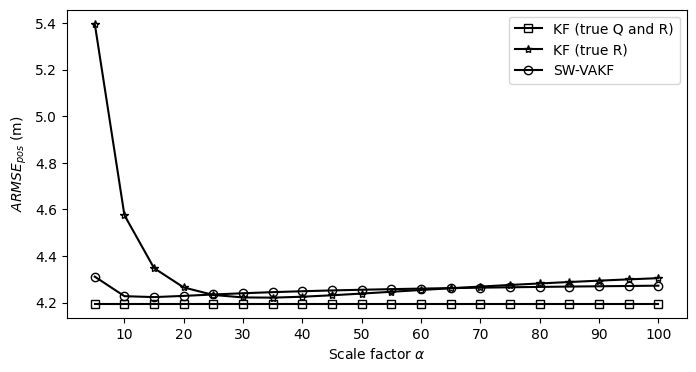

In [10]:
fig, ax = plt.subplots(figsize=(8,4))
ax.plot(alpha_grid, [experiment_result["okf_pos_armse"]] * len(alpha_grid), '-ks',
        markerfacecolor='None', label="KF (true Q and R)")
ax.plot(alpha_grid, experiment_result["kf_pos_armse"], '-k*', 
        markerfacecolor='None', label="KF (true R)")
ax.plot(alpha_grid, experiment_result["swvakf_pos_armse"], '-ko', 
        markerfacecolor='None', label="SW-VAKF")
ax.set_xlabel(r"Scale factor $\alpha$")
ax.set_ylabel(r"$ARMSE_{pos}$ (m)")
ax.legend();
ax.set_xticks(alpha_grid[1::2]);
# ax.set_ylim(4.10, 100.40);

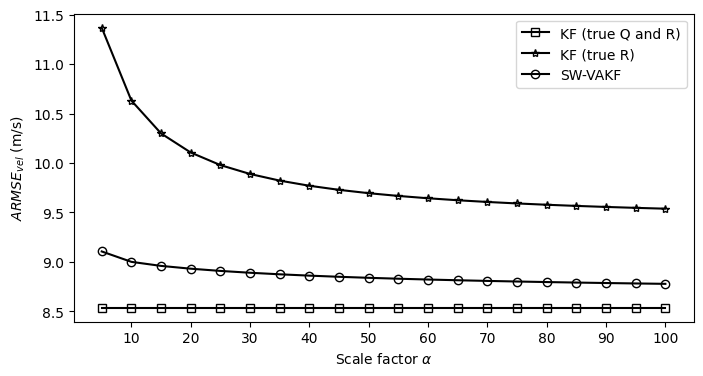

In [11]:
fig, ax = plt.subplots(figsize=(8,4))
ax.plot(alpha_grid, [experiment_result["okf_vel_armse"]] * len(alpha_grid), '-ks',
        markerfacecolor='None', label="KF (true Q and R)")
ax.plot(alpha_grid, experiment_result["kf_vel_armse"], '-k*',
        markerfacecolor='None', label="KF (true R)");
ax.plot(alpha_grid, experiment_result["swvakf_vel_armse"], '-ko', 
        markerfacecolor='None', label="SW-VAKF");
ax.set_xlabel(r"Scale factor $\alpha$")
ax.set_ylabel(r"$ARMSE_{vel}$ (m/s)")
ax.set_xticks(alpha_grid[1::2])
ax.legend();

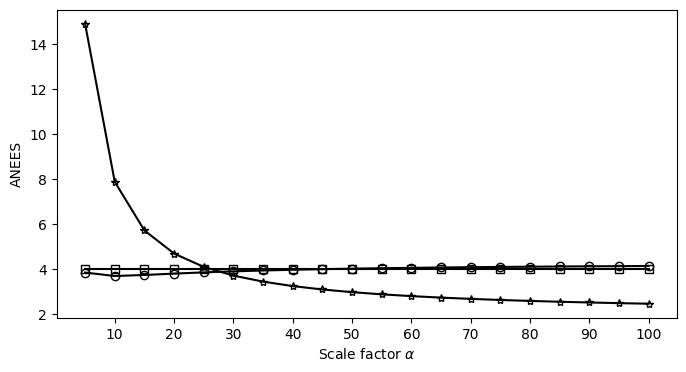

In [12]:
fig, ax = plt.subplots(figsize=(8,4))
ax.plot(alpha_grid, [experiment_result["okf_anees"]] * len(alpha_grid), '-ks',
        markerfacecolor='None', label="KF (true Q and R)")
ax.plot(alpha_grid, experiment_result["kf_anees"], '-k*', 
        markerfacecolor='None', label="KF (true R)");
ax.plot(alpha_grid, experiment_result["swvakf_anees"], '-ko', 
        markerfacecolor='None', label="SW-VAKF");
ax.set_xlabel(r"Scale factor $\alpha$")
ax.set_ylabel(r"ANEES");
ax.set_xticks(alpha_grid[1::2]);

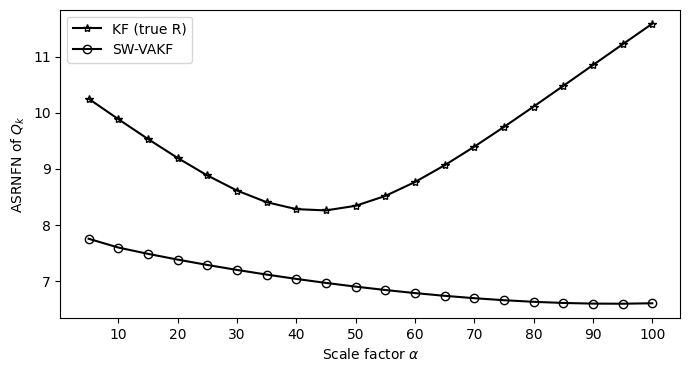

In [13]:
fig, ax = plt.subplots(figsize=(8,4))
ax.plot(alpha_grid, experiment_result["kf_q_asrnfn"], '-k*',
        markerfacecolor='None', label="KF (true R)");
ax.plot(alpha_grid, experiment_result["swvakf_q_asrnfn"], '-ko', 
        markerfacecolor='None', label="SW-VAKF");
ax.set_xlabel(r"Scale factor $\alpha$")
ax.set_ylabel(r"ASRNFN of $Q_k$")
ax.set_xticks(alpha_grid[1::2])
ax.legend();

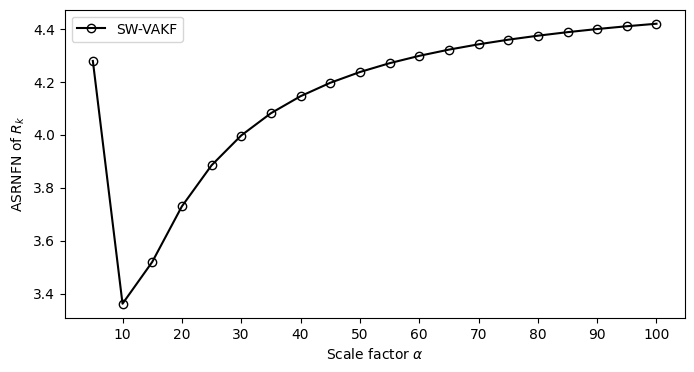

In [14]:
fig, ax = plt.subplots(figsize=(8,4))
ax.plot(alpha_grid, experiment_result["swvakf_r_asrnfn"], '-ko', 
        markerfacecolor='None', label="SW-VAKF");
ax.set_xlabel(r"Scale factor $\alpha$")
ax.set_ylabel(r"ASRNFN of $R_k$")
ax.set_xticks(alpha_grid[1::2])
ax.legend();

# 2. Experiment 2

## 2.1 Dataset

In [44]:
state_dim = 2
obs_dim = 2
f = lambda z: z + 0.4 * jnp.array([jnp.sin(z[1]), jnp.cos(z[0])])
h = lambda z: z
m0 = jnp.array([1.5, 0.0])
P0 = jnp.eye(state_dim)
Q_true = jnp.eye(state_dim) * 0.01
R_true = jnp.eye(obs_dim) * 0.1

params = ParamsNLGSSM(
    initial_mean = m0,
    initial_covariance = P0,
    dynamics_function = f,
    dynamics_covariance = Q_true,
    emission_function = h,
    emission_covariance = R_true
)

nlgssm = NonlinearGaussianSSM(state_dim, obs_dim)

X_train, Y_train = nlgssm.sample(params, jr.PRNGKey(0), num_timesteps=100)

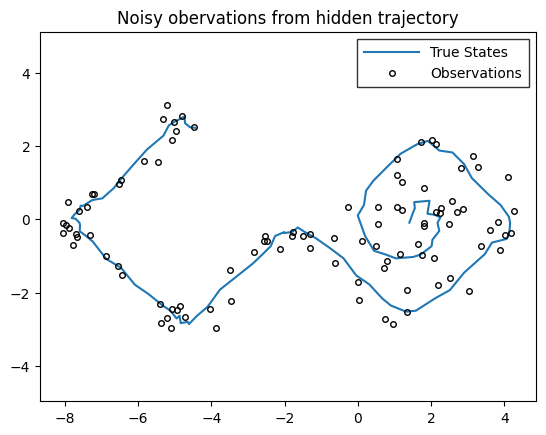

In [45]:
def plot_inference(states, emissions, estimates=None, est_type="", ax=None, title="", aspect=0.8, show_states=True):
    if ax is None:
        fig, ax = plt.subplots()
    if show_states:
        ax.plot(*states.T, label="True States")
    ax.plot(*emissions.T, "ok", fillstyle="none", ms=4, label="Observations")
    if estimates is not None:
        ax.plot(*estimates.T, color="r", linewidth=1.5, label=f"{est_type} Estimate")
    #ax.set_aspect(aspect)
    ax.set_title(title)
    ax.legend(borderpad=0.5, handlelength=4, fancybox=False, edgecolor="k")
    ax.axis('equal')
    return ax

plot_inference(X_train, Y_train, title="Noisy obervations from hidden trajectory");

## 2.2 Experiment

In [51]:
def compute_cov_rmses(window_length):
    # Initial guess for parameters
    Q0, R0 = 5*jnp.eye(state_dim), 5*jnp.eye(obs_dim)

    ada_dynamics_cov = True if window_length >= 1 else False
    ada_emission_cov = True if window_length >= 1 else False
    
    params = SWEKFParams(
        dim_input=state_dim,
        dim_output=obs_dim,
        initial_mean=m0,
        initial_covariance=P0,
        dynamics_function=f,
        dynamics_covariance=Q0,
        emission_mean_function=lambda w, x: w,
        emission_cov_function=None,
        emission_covariance=R0,
        adaptive_dynamics_cov=ada_dynamics_cov,
        adaptive_emission_cov=ada_emission_cov,
        covariance_inflation_factor=1e-5,
        window_length=window_length,
    )
    
    estimator = RebayesSWEKF(params)
    def callback(bel, pred_obs, t, x, y, *args, **kwargs):
        state_rmse = jnp.sqrt(jnp.mean((x - bel.mean) ** 2))
        Q_rmse = jnp.sqrt(jnp.mean((Q_true - bel.dynamics_cov) ** 2))
        R_Rmse = jnp.sqrt(jnp.mean((R_true - bel.emission_cov) ** 2))
        
        return state_rmse, Q_rmse, R_Rmse

    _, output = estimator.scan(X_train, Y_train, callback=callback)
    
    return output

In [47]:
window_length_grid = jnp.array([0, 1, 5, 20,])

outputs = {}
for window_length in window_length_grid:
    outputs[window_length.item()] = compute_cov_rmses(window_length)

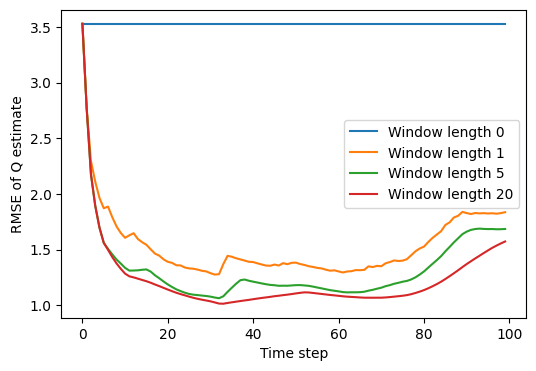

In [32]:
# Q RMSEs
fig, ax = plt.subplots(figsize=(6,4))
for key, val in outputs.items():
    q_rmse = val[1]
    ax.plot(q_rmse, label=f"Window length {key}")
ax.set_xlabel("Time step")
ax.set_ylabel("RMSE of Q estimate")
ax.legend();

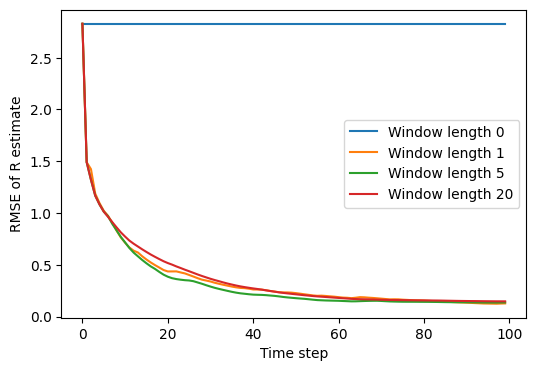

In [33]:
# R RMSEs
fig, ax = plt.subplots(figsize=(6,4))
for key, val in outputs.items():
    q_rmse = val[2]
    ax.plot(q_rmse, label=f"Window length {key}")
ax.set_xlabel("Time step")
ax.set_ylabel("RMSE of R estimate")
ax.legend();

# 3. Experiment 3

## 3.1 Dataset

In [13]:
def generate_dataset_3(n_train=500, n_test=1_000, obs_var=0.1, key=0, trenches=False, sort_data=False):
    if isinstance(key, int):
        key = jr.PRNGKey(key)
    key1, key2, subkey1, subkey2, key_shuffle = jr.split(key, 5)

    n_train_sample = 2 * n_train if trenches else n_train
    X_train = jr.uniform(key1, shape=(n_train_sample, 1), minval=0.0, maxval=0.5)
    X_test = jr.uniform(key2, shape=(n_test, 1), minval=0.0, maxval=0.5)

    def generating_function(key, x):
        epsilon = jr.normal(key)*jnp.sqrt(obs_var)
        return x + 0.3*jnp.sin(2*jnp.pi*x) + 0.3*jnp.sin(4*jnp.pi*x) + epsilon

    keys_train = jr.split(subkey1, X_train.shape[0])
    keys_test = jr.split(subkey2, X_test.shape[0])
    y_train = vmap(generating_function)(keys_train, X_train)
    y_test = vmap(generating_function)(keys_test, X_test)

    n_train = len(X_train)
    ixs = jr.choice(key_shuffle, shape=(n_train,), a=n_train, replace=False)
    X_train = X_train[ixs]
    y_train = y_train[ixs]

    return (X_train, y_train), (X_test, y_test)

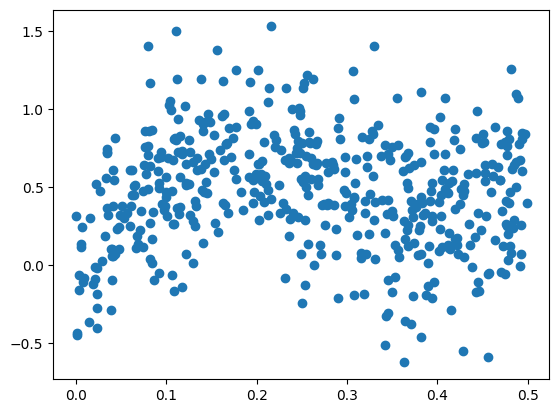

In [15]:
(X2_train, y2_train), (X2_test, y2_test) = generate_dataset_3(obs_var=0.1)
plt.scatter(X2_train, y2_train);

## 3.2 Experiment

In [16]:
input_dim, hidden_dims, output_dim = 1, [20,], 1
model_dims = [input_dim, *hidden_dims, output_dim]
_, flat_params3, _, apply_fn3 = get_mlp_flattened_params(model_dims, jr.PRNGKey(0), nn.gelu)
print(flat_params3.shape)

(61,)


In [18]:
def run_experiment3(alpha_grid, n_train=500, n_test=1_000, obs_var=0.02, n_iter=10, key=0):
    if isinstance(key, int):
        key = jr.PRNGKey(key)

    # True parameters
    D, *_ = flat_params3.shape
    
    def rmse_callback(bel, *args, **kwargs):
        X_test, y_test = kwargs["X_test"], kwargs["y_test"]
        apply_fn = kwargs["apply_fn"]
        
        yhat = apply_fn(bel.mean, X_test)
        err = jnp.sqrt(((y_test - yhat)**2).mean())
        
        return err

    def run_single_iter(key):
        # Generate data with random seed
        (X_train, y_train), (X_test, y_test) = generate_dataset_3(n_train, n_test, obs_var, key)
        test_kwargs = {"X_test": X_test, "y_test": y_test, "apply_fn": apply_fn3}
        
        # Run and evaluate Kalman Filter
        def run_ekf(alpha):
            ekf_params = EKFParams(
                initial_mean = flat_params3,
                initial_covariance = 10.0 * jnp.eye(D),
                dynamics_weights_or_function = 1.0,
                dynamics_covariance = 0.0,
                emission_mean_function = apply_fn3,
                emission_cov_function = lambda w, x: jnp.eye(1) * alpha,
            )
            estimator = RebayesEKF(ekf_params, "fcekf")
            _, output = estimator.scan(X_train, y_train, rmse_callback, **test_kwargs)
            
            return output
        ekf_rmses = vmap(run_ekf)(alpha_grid)
        
        # Run and evaluate SW-KF (fixed Q)
        def run_swekf(alpha):
            swekf_params = SWEKFParams(
                dim_input = 1,
                dim_output = 1,
                initial_mean = flat_params3,
                initial_covariance = 10.0 * jnp.eye(D),
                dynamics_function = lambda x: x,
                dynamics_covariance = 0.0 * jnp.eye(D),
                emission_mean_function = apply_fn3,
                emission_cov_function = None,
                emission_covariance = jnp.eye(1) * alpha,
                adaptive_dynamics_cov = False,
                adaptive_emission_cov = True,
                covariance_inflation_factor = 1e-4,
                window_length = 5,
            )
            estimator = RebayesSWEKF(swekf_params)
            _, output = estimator.scan(X_train, y_train, rmse_callback, **test_kwargs)
            
            return output
        swekf_rmses = vmap(run_swekf)(alpha_grid)

        result = {
            "ekf": ekf_rmses,
            "swekf": swekf_rmses,
        }

        return result
    
    keys = jr.split(key, n_iter)
    result = vmap(run_single_iter)(keys)
    result = tree_map(lambda x: jnp.mean(x, axis=0), result) # Mean across MC trials

    return result

In [23]:
alpha_grid = jnp.array([1e-2, 1e-1, 1.0, 10.0])
result = run_experiment3(alpha_grid, n_iter=10)
ekf_result = result["ekf"]
swekf_result = result["swekf"]

In [24]:
swekf_result

Array([[0.3  , 0.307, 0.287, ..., 0.152, 0.152, 0.152],
       [0.3  , 0.291, 0.279, ..., 0.152, 0.152, 0.152],
       [0.293, 0.272, 0.268, ..., 0.152, 0.153, 0.153],
       [0.285, 0.279, 0.273, ..., 0.153, 0.154, 0.154]], dtype=float32)

In [25]:
ekf_result

Array([[0.3  , 0.307, 0.318, ..., 0.145, 0.145, 0.145],
       [0.3  , 0.291, 0.29 , ..., 0.149, 0.149, 0.149],
       [0.293, 0.272, 0.269, ..., 0.162, 0.162, 0.162],
       [0.285, 0.279, 0.273, ..., 0.195, 0.195, 0.195]], dtype=float32)

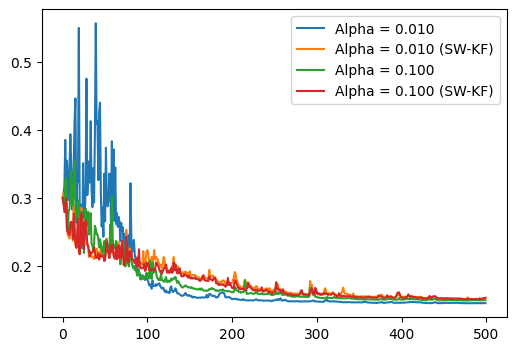

In [28]:
fig, ax = plt.subplots(figsize=(6,4))
for i, alpha in enumerate(alpha_grid[:2]):
    ax.plot(ekf_result[i], label=f"Alpha = {alpha:.3f}")
    ax.plot(swekf_result[i], label=f"Alpha = {alpha:.3f} (SW-KF)")

ax.legend();

# 4. Misc.

## 3.1 Dataset

In [20]:
key = jax.random.PRNGKey(314)
n_dist = 6
n_train = 100
data_flat, data_tasks = datagen.sample_1d_regression_sequence(key, n_dist, n_train=n_train)
jax.tree_map(jnp.shape, data_flat)

{'test': {'X': (600, 1), 'id_seq': (600,), 'y': (600, 1)},
 'train': {'X': (600, 1), 'id_seq': (600,), 'y': (600, 1)}}

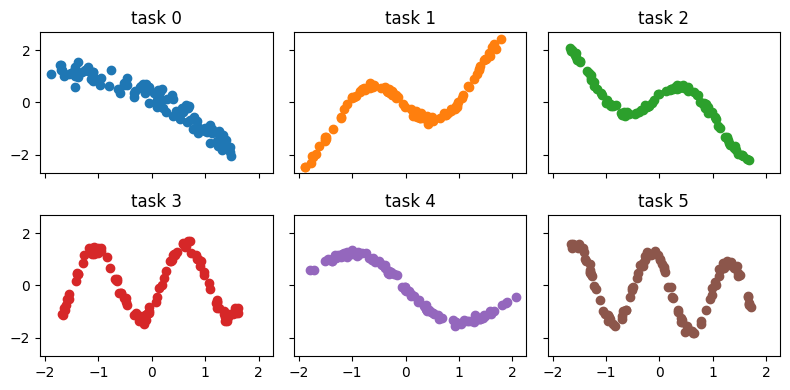

In [21]:
fig, axs = plt.subplots(2, 3, figsize=(8, 4), sharex=True, sharey=True)

colors = plt.cm.tab10(jnp.arange(n_dist))
for n, ax in enumerate(axs.ravel()):
    data_slice = datagen.slice_tasks(data_flat, n)
    c=colors[n]
    ax.scatter(data_slice["train"]["X"], data_slice["train"]["y"], color=c)
    ax.set_title(f"task {n}")
plt.tight_layout()

In [22]:
class MLP(nn.Module):
    n_out: int
    n_hidden: int
    activation: Callable = nn.tanh
    
    @nn.compact
    def __call__(self, x):
        x = nn.Dense(self.n_hidden)(x)
        x = self.activation(x)
        x = nn.Dense(self.n_out)(x)
        return x
    
def make_bnn_flax(nhidden=50):
    key = jax.random.PRNGKey(314)
    dim_out = 1
    dim_in = 1 
    model = MLP(dim_out, nhidden)
    params = model.init(key, jnp.ones((1, dim_in)))
    flat_params, recfn = ravel_pytree(params)
    n_params = len(flat_params)
    return model, params, flat_params, recfn

In [23]:
model, dnn_params, flat_params, recfn = make_bnn_flax()

X_train_seq = data_flat["train"]["X"]
Y_train_seq = data_flat["train"]["y"]
train_id_seq = data_flat["train"]["id_seq"]

X_test_seq = data_flat["test"]["X"]
Y_test_seq = data_flat["test"]["y"]
test_id_seq = data_flat["test"]["id_seq"]

X_test_tasks = data_tasks["train"]["X"]
Y_test_tasks = data_tasks["train"]["y"]
X_train_tasks = data_tasks["train"]["X"]
Y_train_tasks = data_tasks["train"]["y"]

## 3.1 Experiment

In [24]:
n_samples = 55
xeval = jnp.linspace(-2.0, 2.0, num=100)[:, None]

def callback(bel, pred_obs, t, Xt, Yt, bel_pred, apply_fn, agent, **kwargs):    
    # eval on all tasks test set
    yhat = apply_fn(bel.mean, X_test_seq).squeeze()
    ytrue = Y_test_seq.squeeze()
    rmse_test_all_tasks = jnp.mean(jnp.square(yhat - ytrue)) 

    # eval on current task 
    task = train_id_seq[t]
    yhat = apply_fn(bel.mean, X_test_tasks[task]).squeeze()

    ytrue = Y_test_tasks[task].squeeze()
    rmse_test_current_task = jnp.sqrt(jnp.mean(jnp.square(yhat - ytrue)))
    mae_test_current_task = jnp.mean(jnp.abs(yhat - ytrue))
    
    key_step = jax.random.fold_in(key, t)
    yhat_samples = agent.pred_obs_mc(key_step, bel, xeval, shape=(n_samples,))


    out = {'rmse_test_all_tasks': rmse_test_all_tasks,
           'rmse_test_current_task': rmse_test_current_task,
           'mae_test_current_task': mae_test_current_task,
           'pred_test_current_task': yhat,
           "yhat_samples": yhat_samples,
           }
    return out

In [25]:
# FCEKF
def apply_fn_flat(flat_params, x):
    return model.apply(recfn(flat_params), x)

def apply_fn_unflat(params, x):
    return model.apply(params, x)

fcekf_params = EKFParams(
    initial_mean=flat_params,
    initial_covariance=0.06 * jnp.eye(len(flat_params)),
    dynamics_weights_or_function=1.0,
    dynamics_covariance=1e-7,
    emission_mean_function=apply_fn_flat,
    emission_cov_function=lambda w, x: 0.02,
    dynamics_covariance_inflation_factor=0.001,
)
fcekf_estimator = RebayesEKF(fcekf_params, method="fcekf")
fcekf_callback = partial(callback, apply_fn=apply_fn_flat, agent=fcekf_estimator)

_, fcekf_outputs = fcekf_estimator.scan(X_train_seq, Y_train_seq, callback=fcekf_callback)

In [26]:
# SWVAKF
swekf_params = SWEKFParams(
    dim_input = 1,
    dim_output = 1,
    initial_mean = flat_params,
    initial_covariance = 0.06 * jnp.eye(len(flat_params)),
    dynamics_function=lambda w: w,
    dynamics_covariance=1e-7*jnp.eye(len(flat_params)),
    emission_mean_function=apply_fn_flat,
    emission_cov_function=None,
    emission_covariance=0.02*jnp.eye(1),
    covariance_inflation_factor=jnp.exp(-4),
    window_length=5,
)
swekf_estimator = RebayesSWEKF(swekf_params)
swekf_callback = partial(callback, apply_fn=apply_fn_flat, agent=swekf_estimator)

bel, swekf_outputs = swekf_estimator.scan(X_train_seq, Y_train_seq, callback=swekf_callback)

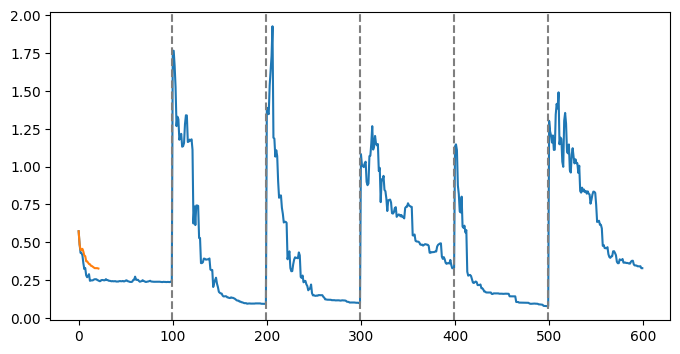

In [27]:
ntasks, ntrain_per_task, _ = X_train_tasks.shape
changepoints = jnp.arange(ntrain_per_task, (ntasks)*ntrain_per_task, step=ntrain_per_task)-1

fig, ax = plt.subplots(figsize=(8,4))
ax.plot(fcekf_outputs['rmse_test_current_task'], label="FCEKF");
ax.plot(swekf_outputs['rmse_test_current_task'], label="SWEKF");
for c in changepoints:
    plt.axvline(x=c, color="tab:gray", linestyle="--")